# Embeddings

In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.models import Sequential

## Loading the data

In [2]:
with h5py.File('/data/joint_scoring/labels_test_regression.h5', 'r') as hf:
    y = hf['labels_test_regression'][:]
    
with h5py.File('/data/joint_scoring/img_test_regression.h5', 'r') as hf:
    imgs = hf['img_test_regression'][:]

imgs = imgs
y = y

y.shape, imgs.shape

((19709,), (19709, 150, 150, 1))

In [3]:
from tensorflow.python.keras import backend as K

def crps(y_true, y_pred):
    diff = (y_true - y_pred)
    diff_2 = K.square(diff)
    loss = K.mean(diff_2)
    return loss

In [4]:
from tensorflow.python.keras.models import load_model

loaded_model = load_model("/data/joint_scoring/models/20171104_135018.h5", custom_objects={"crps":crps})

In [5]:
p = loaded_model.predict(imgs)

In [6]:
pred = np.zeros(p.shape[0])

for i in range(p.shape[0]):
    pred[i] = sum(1 - p[i])

In [7]:
diff = pred - y

In [8]:
diff

array([ 0.92763996,  0.48160774,  0.4225744 , ...,  0.78341782,
        0.22367388,  4.32695609])

## Build truncated model

In [9]:
config = loaded_model.get_config()

In [10]:
config = config[0:48]

In [11]:
model = Sequential.from_config(config)

In [12]:
weights = loaded_model.get_weights()

In [13]:
model.set_weights(weights)

## Get embeddings

In [14]:
embeddings = model.predict(imgs)

In [17]:
from sklearn.decomposition import PCA
x_50d = PCA(n_components=50).fit_transform(embeddings)

In [18]:
from sklearn.manifold import TSNE
x_2d = TSNE(n_components=2, random_state=1).fit_transform(x_50d)

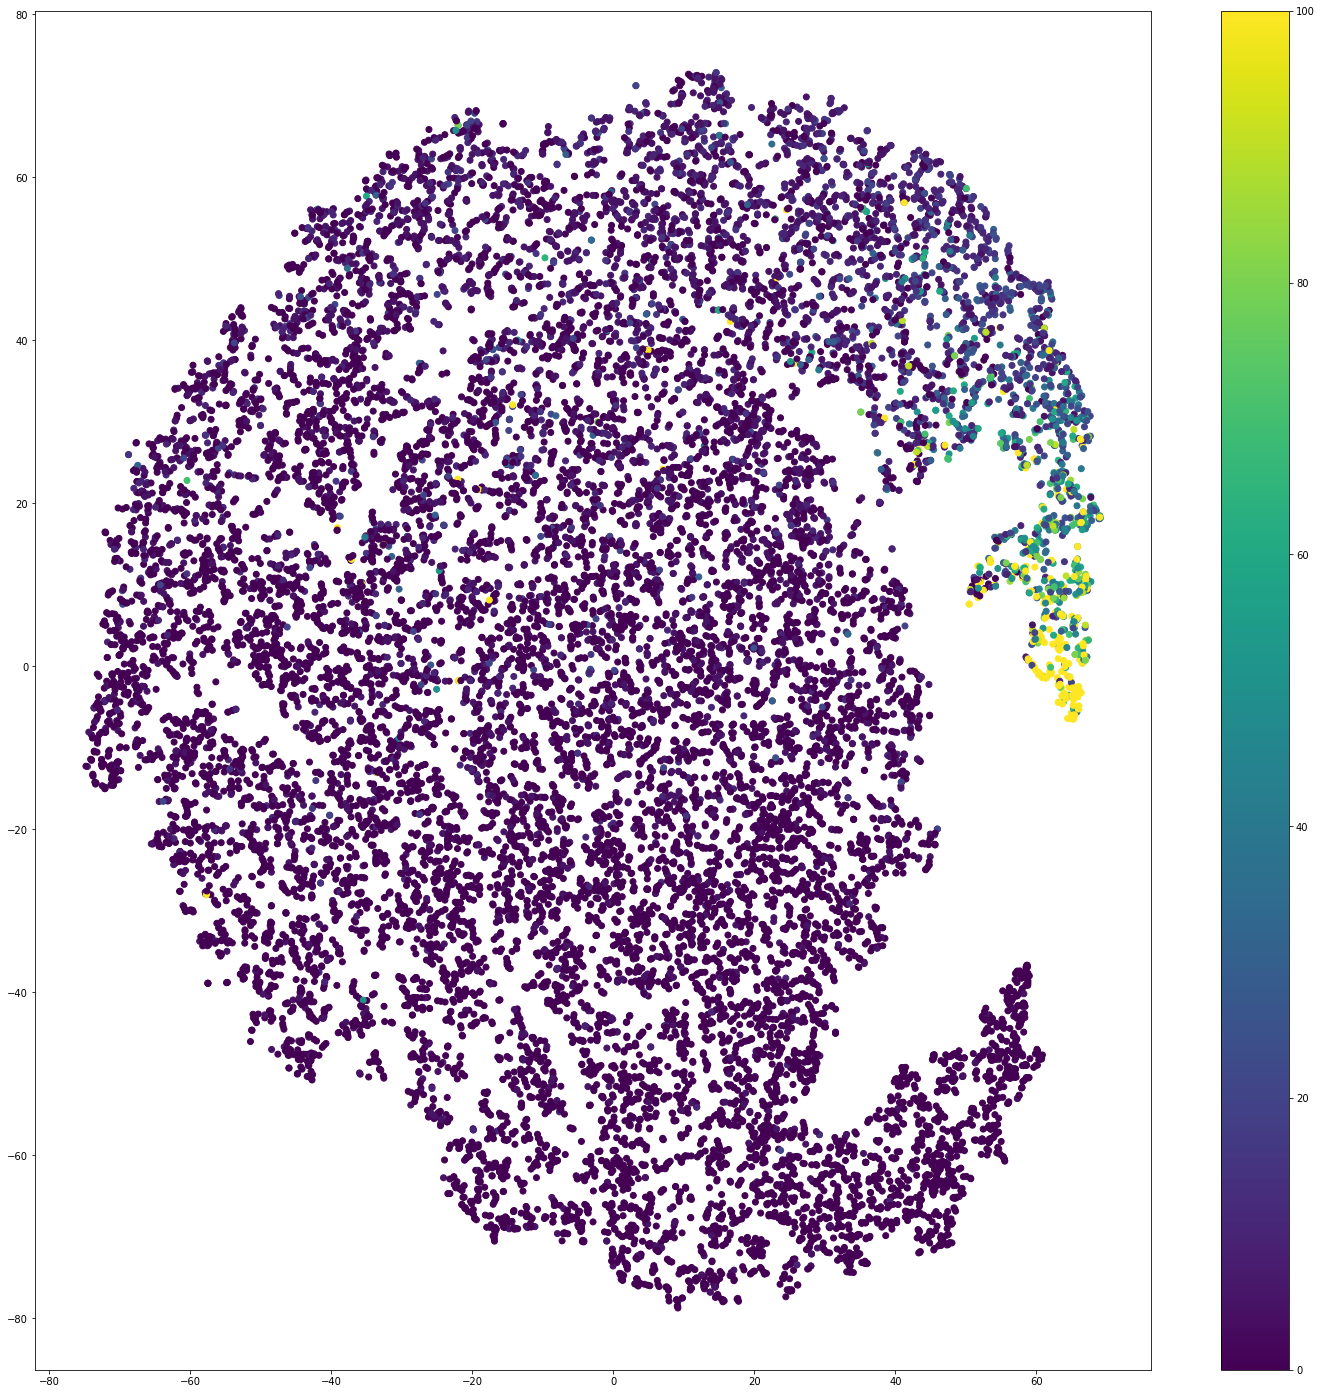

In [19]:
from matplotlib import pyplot as plt

plt.figure(figsize=(25,25))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y, cmap=plt.cm.get_cmap("viridis"))
plt.colorbar()
plt.show()

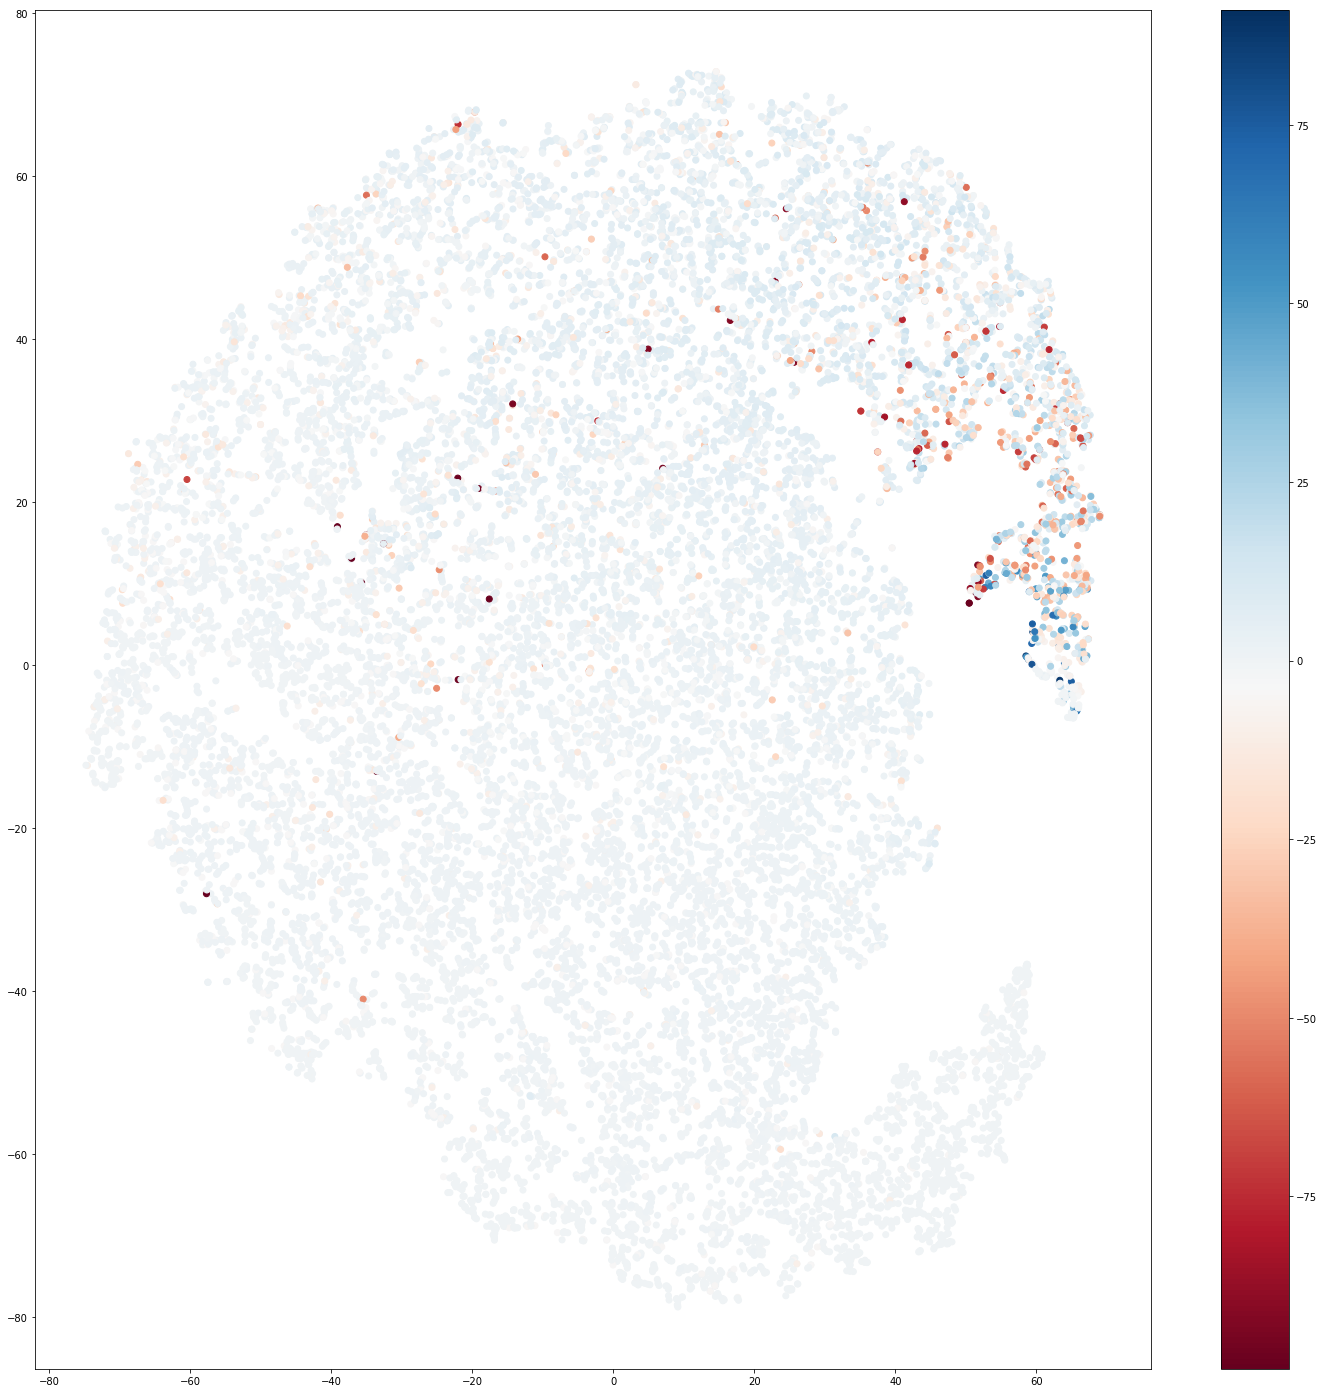

In [20]:
from matplotlib import pyplot as plt

plt.figure(figsize=(25,25))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=diff, cmap=plt.cm.get_cmap("RdBu"))
plt.colorbar()
plt.show()

In [21]:
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=3, random_state=1).fit_transform(x_50d)

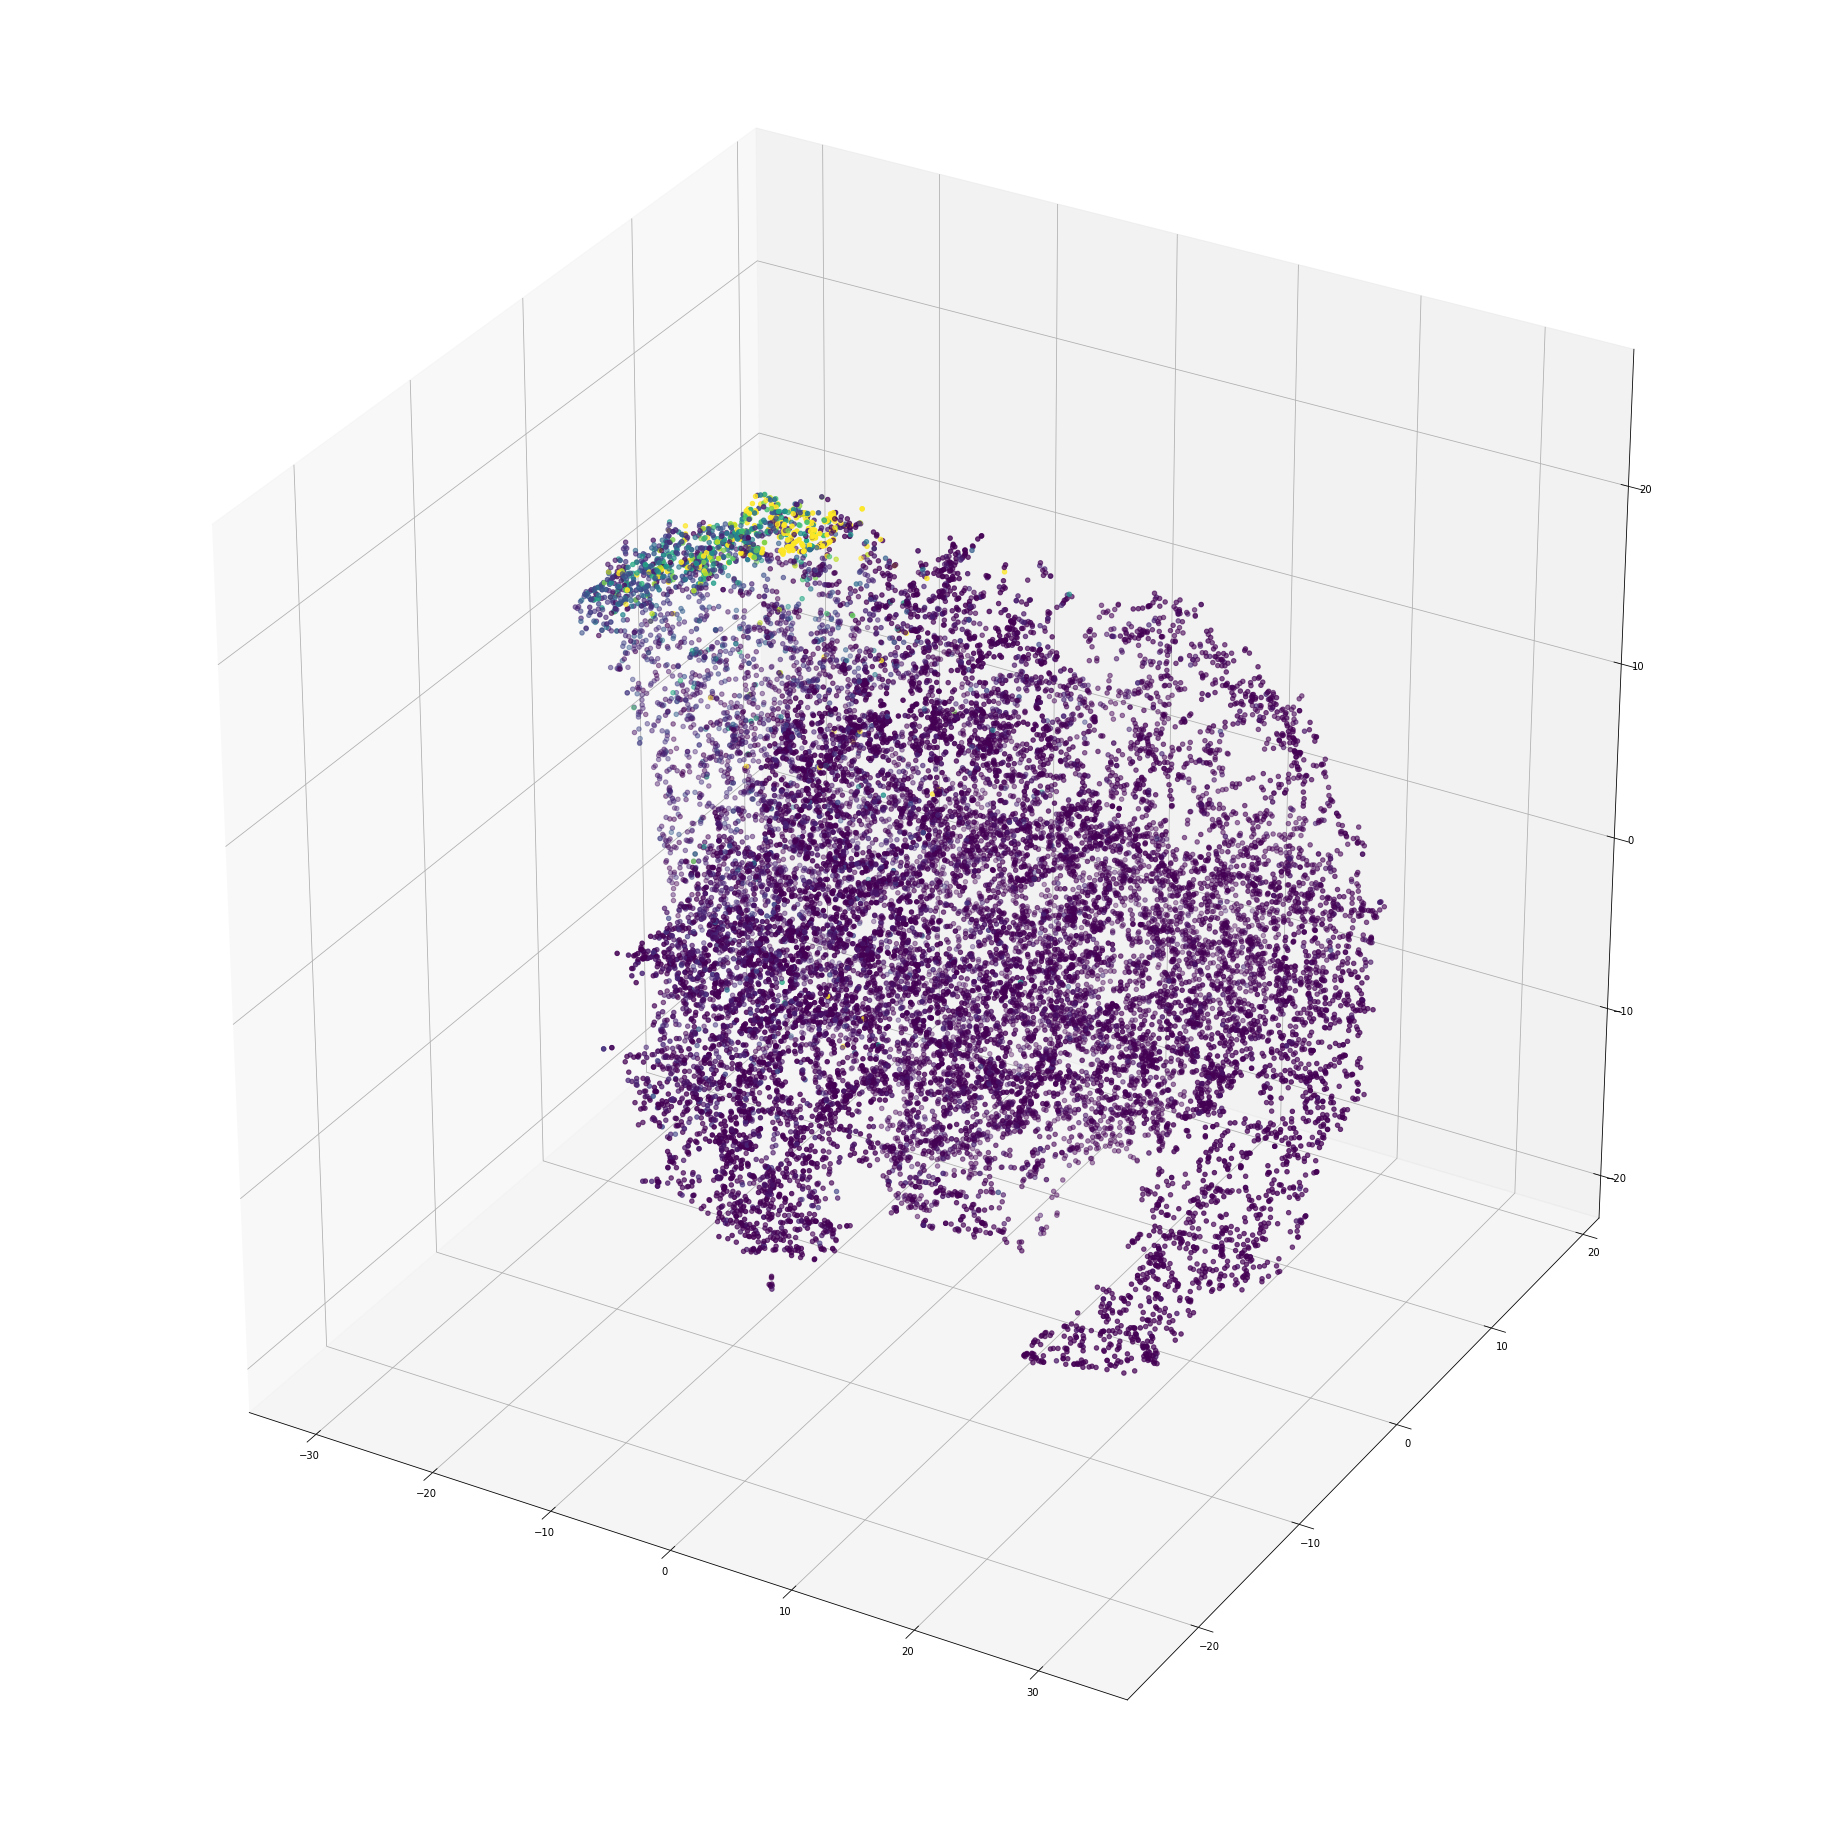

In [22]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure(figsize=(25,25))
ax = Axes3D(fig)
ax.scatter(x_embedded[:, 0], x_embedded[:, 1], x_embedded[:, 2], c=y, cmap=plt.cm.get_cmap("viridis"))
pyplot.show()

In [24]:
!pip3 install scikit-image --upgrade
from skimage.transform import resize
imgs_resized = [resize(image=x, output_shape=(25, 25)) for x in imgs]
imgs_resized = np.array(imgs_resized)

    100% |################################| 35.5MB 40kB/s  eta 0:00:01
    100% |################################| 1.6MB 694kB/s ta 0:00:011
    100% |################################| 5.7MB 218kB/s eta 0:00:01
Requirement already up-to-date: scipy>=0.17.0 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: matplotlib>=1.3.1 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: six>=1.7.3 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: pillow>=2.1.0 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: decorator>=4.1.0 in /usr/local/lib/python3.5/dist-packages (from networkx>=1.8->scikit-image)
Requirement already up-to-date: numpy>=1.9.1 in /usr/local/lib/python3.5/dist-packages (from PyWavelets>=0.4.0->scikit-image)
Requirement already up-to-date: pytz in /usr/local/lib/python3.5/dist-packages (from matplotlib>=1.3.1->

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [25]:
from IPython.display import clear_output
res = 4000 # resolution of plot
cval = 255 # background colour

images = imgs_resized
max_width = max([image.shape[0] for image in images])
max_height = max([image.shape[1] for image in images])

In [26]:
f2d = x_2d

xx = f2d[:, 0]
yy = f2d[:, 1]
x_min, x_max = xx.min(), xx.max()
y_min, y_max = yy.min(), yy.max()
# Fix the ratios
sx = (x_max-x_min)
sy = (y_max-y_min)
if sx > sy:
    res_x = sx/float(sy)*res
    res_y = res
else:
    res_x = res
    res_y = sy/float(sx)*res

In [27]:
res_x, res_y

(4000, 4215.9815420046252)

In [28]:
res_y=res_y.astype("int16")

In [29]:
images[0].shape

(25, 25, 1)

In [30]:
canvas = np.ones((res_x+max_width, res_y+max_height, 3))*cval
x_coords = np.linspace(x_min, x_max, res_x)
y_coords = np.linspace(y_min, y_max, res_y)
i = 0
for x, y, image in zip(xx, yy, images):
    clear_output()
    print("Creating plot, {0:.2f} % finished".format(i/19611*100))
    i = i + 1
    w, h = image.shape[:2]
    x_idx = np.argmin((x - x_coords)**2)
    y_idx = np.argmin((y - y_coords)**2)
    canvas[x_idx:x_idx+w, y_idx:y_idx+h] = image

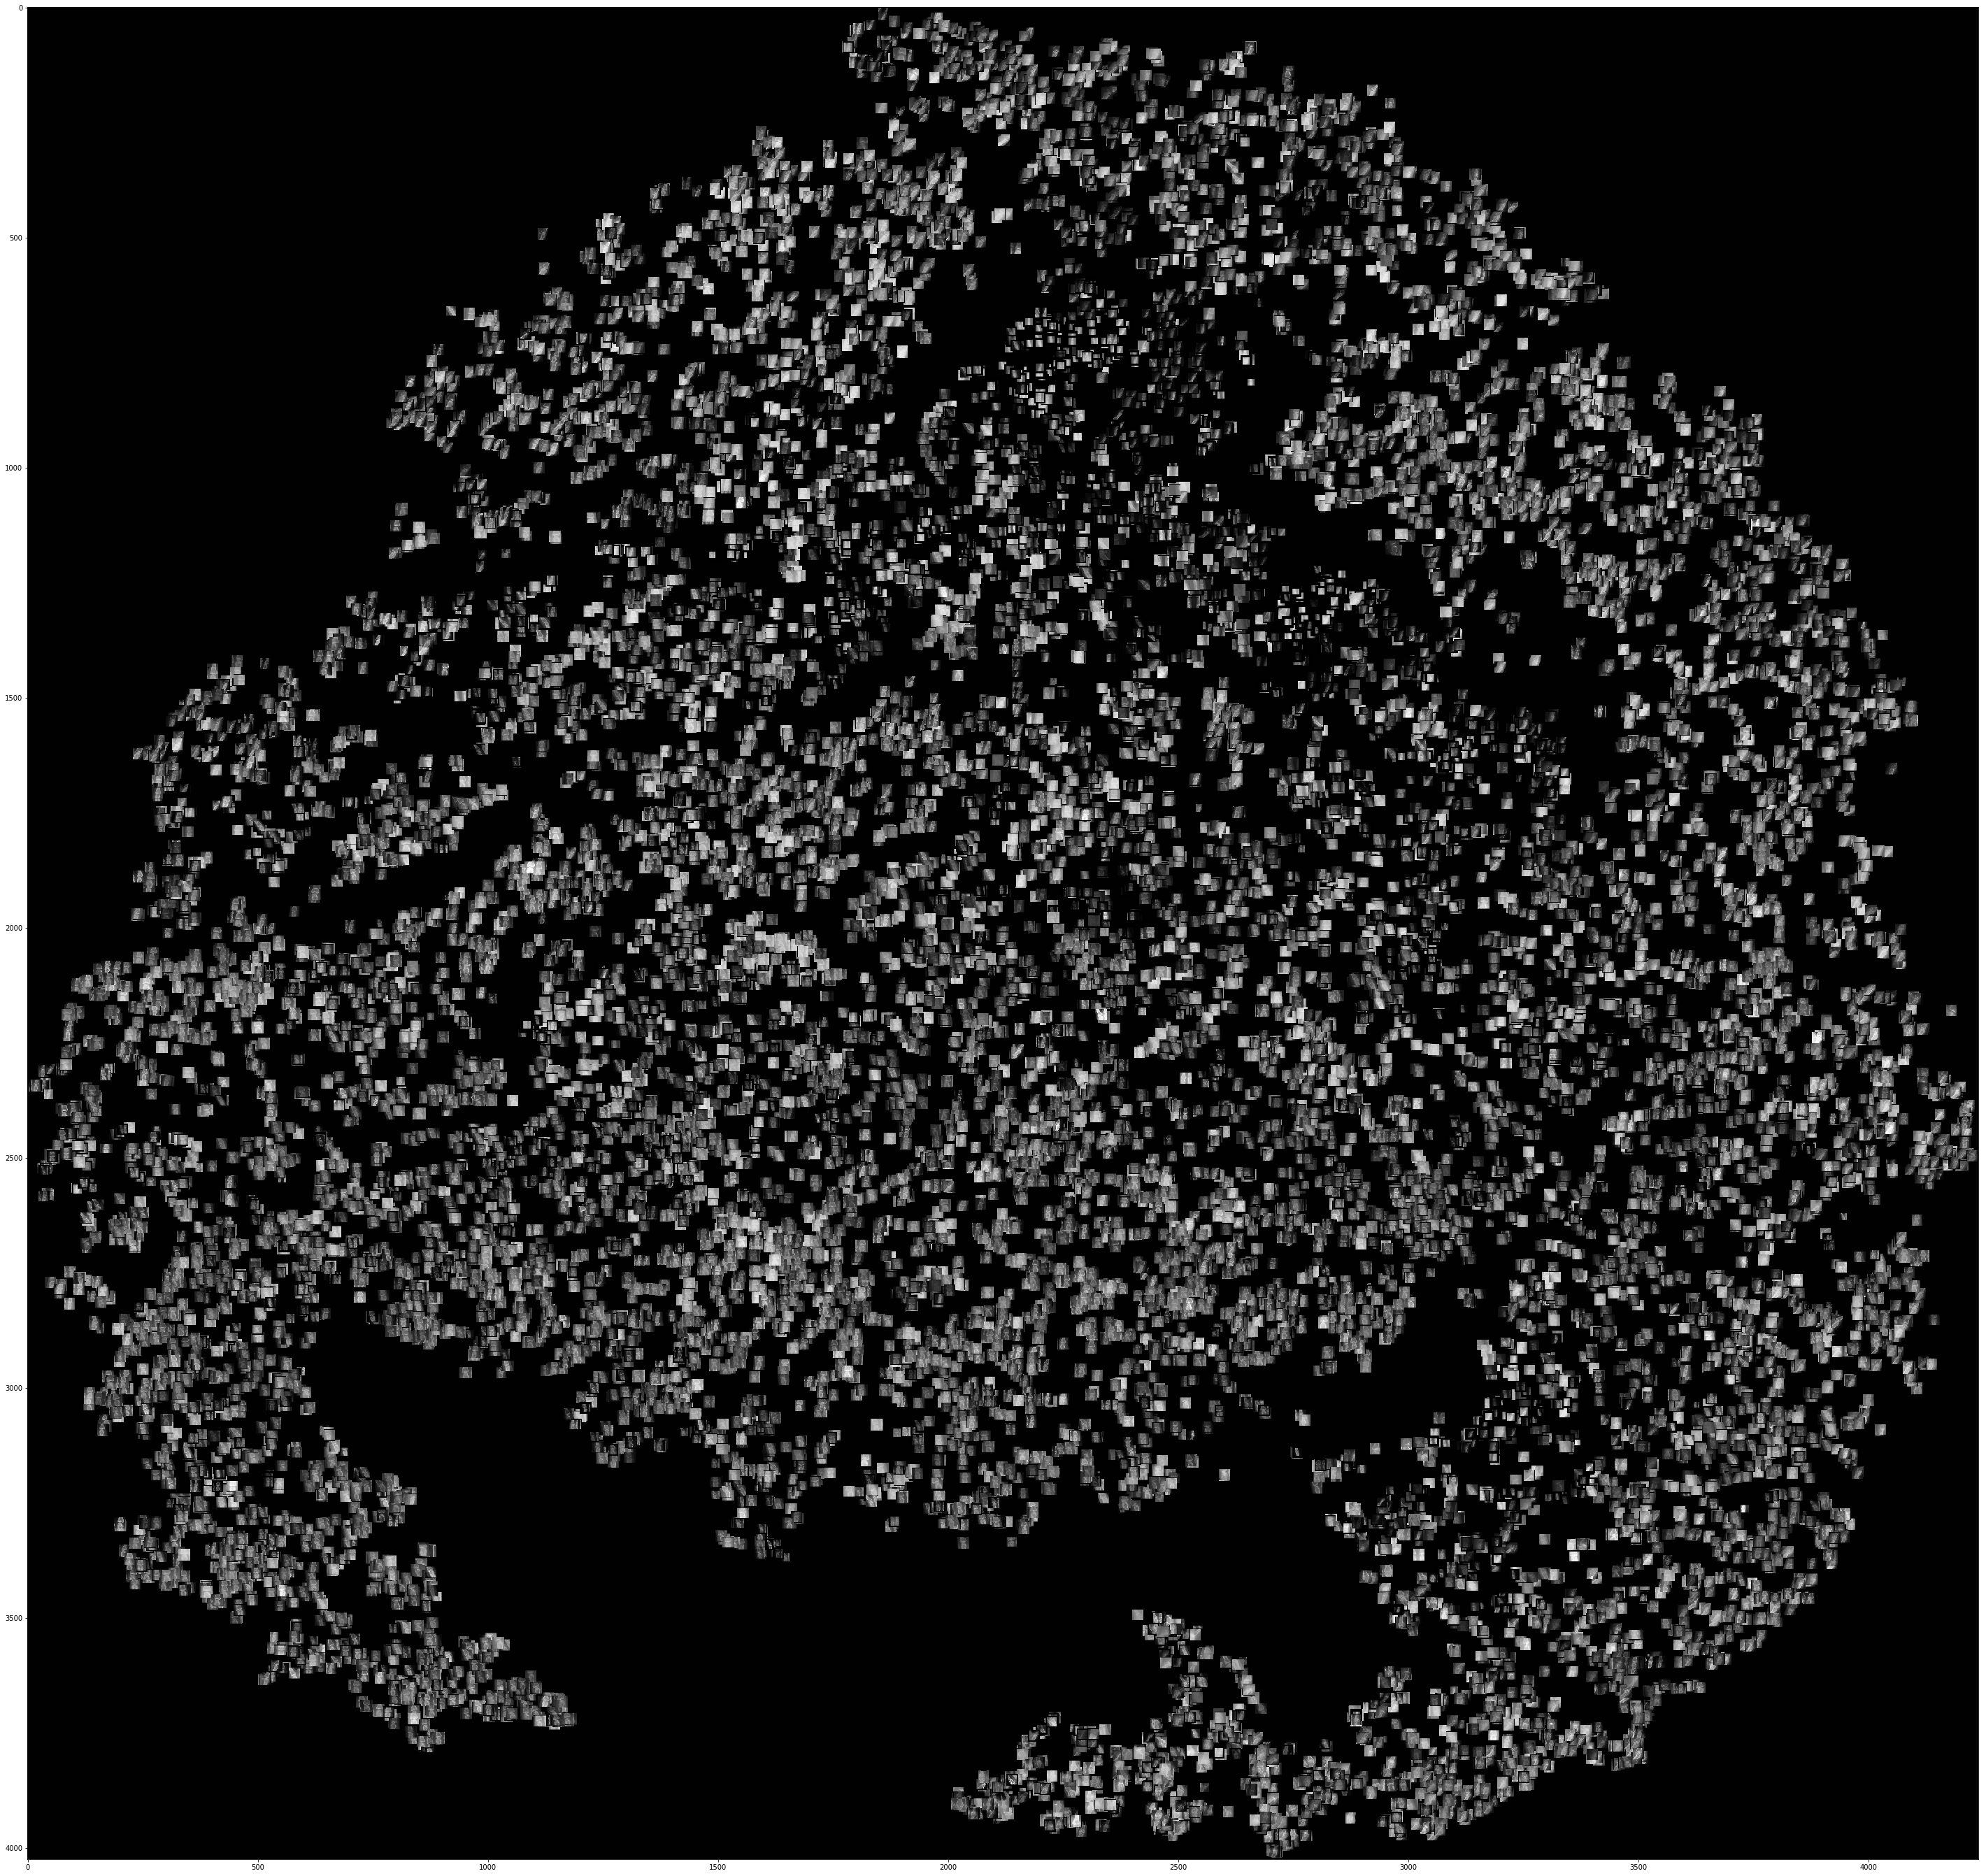

In [32]:
plt.figure(figsize=(50,50))
plt.imshow(canvas)
plt.show()